# Build array geometry

This notebook can be used to build the geometry files describing potential array/antenna configurations for subsequent analysis.

In [1]:
%matplotlib ipympl

import numpy as np
import obspy.geodetics
import pandas as pd

PHI = (1 + np.sqrt(5)) / 2

In [4]:
def build_cross_antenna_geometry(lon_0, lat_0, n_lon, n_lat, d_lon, d_lat):
    '''
    Return geometry for standard (cross) antenna.
    
    Arguments
    =========
    lon_0 :: float :: (Degrees) Longitude of center of antenna.
    lat_0 :: float :: (Degrees) Latitude of center of antenna.
    n_lon :: int :: (Count) Number of nodes along longitudinal axis.
    n_lat :: int :: (Count) Number of nodes along latitudinal axis.
    d_lon :: float :: (Degrees) Node separation along longitudinal axis.
    d_lat :: float :: (Degrees) Node separation along latitudinal axis.
    
    Returns
    =======
    geom :: pandas.DataFrame :: Fields are [location, longitude, latitude, x, y].
    '''
    longitude = np.concatenate([
        [lon_0],
        lon_0 - (np.arange(n_lon//2)+1)*d_lon,
        lon_0 + (np.arange(n_lon//2)+1)*d_lon,
        np.repeat(lon_0, n_lat)
    ])
    latitude = np.concatenate([
        [lat_0],
        np.repeat(lat_0, n_lon),
        lat_0 - (np.arange(n_lat//2)+1)*d_lat,
        lat_0 + (np.arange(n_lat//2)+1)*d_lat,
    ])
    
    location_codes = np.concatenate([
        ['00'], 
        [f'W{i+1:d}' for i in range(n_lon//2)],
        [f'E{i+1:d}' for i in range(n_lon//2)],
        [f'S{i+1:d}' for i in range(n_lat//2)],
        [f'N{i+1:d}' for i in range(n_lat//2)],
    ])
    
    geom = pd.DataFrame(
        dict(
            location=location_codes,
            longitude=longitude,
            latitude=latitude
        )
    )
    
    return convert_coordinates(geom)

def build_lp_ortho_antenna_geometry(lon_0, lat_0, n_lon, n_lat, d_lon, d_lat, sigma_lon, sigma_lat, recenter=False):
    '''
    Return geometry for orthogonal antenna with log-periodic receiver spacing.
    
    Arguments
    =========
    lon_0 :: float :: (Degrees) Longitude of center of antenna.
    lat_0 :: float :: (Degrees) Latitude of center of antenna.
    n_lon :: int :: (Count) Number of nodes along longitudinal axis.
    n_lat :: int :: (Count) Number of nodes along latitudinal axis.
    d_lon :: float :: (Degrees) Node separation along longitudinal axis.
    d_lat :: float :: (Degrees) Node separation along latitudinal axis.
    sigma_lon :: float :: (Unitless) Geometric factor controlling
        growth rate of receiver spacing along longitudinal axis.
    sigma_lat :: float :: (Unitless) Geometric factor controlling
        growth rate of receiver spacing along latitudinal axis.
    
    Returns
    =======
    geom :: pandas.DataFrame :: Fields are [location, longitude, latitude, x, y].
    '''
    longitude = np.concatenate([
        [lon_0],
        np.repeat(lon_0, n_lat),
        [lon_0 + np.sum(d_lon * sigma_lon**np.arange(i+1)) for i in range(n_lon)],
    ])
    latitude = np.concatenate([
        [lat_0],
        [lat_0 + np.sum(d_lat * sigma_lat**np.arange(i+1)) for i in range(n_lat)],
        np.repeat(lat_0, n_lon)
    ])
    
    location_codes = np.concatenate([
        ['00'], 
        [f'W{i+1:d}' for i in range(n_lon//2)],
        [f'E{i+1:d}' for i in range(n_lon//2)],
        [f'S{i+1:d}' for i in range(n_lat//2)],
        [f'N{i+1:d}' for i in range(n_lat//2)],
    ])
    
    geom = pd.DataFrame(
        dict(
            location=location_codes,
            longitude=longitude,
            latitude=latitude
        )
    )
    
    geom = convert_coordinates(geom)

    if recenter is True:
        d_x = (geom['x'].max() - geom['x'].min()) / 2
        d_y = (geom['y'].max() - geom['y'].min()) / 2
        geom['x'] -= d_x
        geom['y'] -= d_y

    return geom


def build_ring_antenna_geometry(lon_0, lat_0, n_rx_per_layer, radii):
    '''
    Return geometry for circular/ring antenna.
    
    Arguments
    =========
    lon_0 :: float :: (Degrees) Longitude of center of antenna.
    lat_0 :: float :: (Degrees) Latitude of center of antenna.
    n_rx_per_layer :: int :: (Count) Number of receivers in each ring.
    radii :: float/array(float) :: (Degrees) Radius of single ring or
        radii if multiple rings. Either a single float or array-like of
        floats.

    Returns
    =======
    geom :: pandas.DataFrame :: Fields are [location, longitude, latitude, x, y].
    '''
    longitude = np.array([lon_0])
    latitude = np.array([lat_0])
    theta = np.arange(0, 2 * np.pi, 2*np.pi/n_rx_per_layer)
    for i_rad, radius in enumerate(radii):
        theta_offset = i_rad * 2 * np.pi/ n_rx_per_layer / len(radii)
        longitude = np.concatenate([
            longitude,
            lon_0 + radius * np.cos(theta+theta_offset)
        ])
        latitude = np.concatenate([
            latitude,
            lat_0  + radius * np.sin(theta+theta_offset)
        ])
    
    
    location_codes = np.concatenate([
        ['00'],
        [f'{i_layer+1:02d}{i_rx+1:02d}' for i_layer in range(len(radii)) for i_rx in range(n_rx_per_layer)]
    ])
    
    geom = pd.DataFrame(
        dict(
            location=location_codes,
            longitude=longitude,
            latitude=latitude
        )
    )
    
    return convert_coordinates(geom)

def build_spiral_antenna_geometry(lon_0, lat_0, n_arms, n_rx_per_arm, r_0):
    '''
    Return geometry for spiral antenna.
    
    Arguments
    =========
    lon_0 :: float :: (Degrees) Longitude of center of antenna.
    lat_0 :: float :: (Degrees) Latitude of center of antenna.
    n_arms :: int :: (Count) Number of arms in spiral.
    n_rx_per_arm :: int :: (Count) Number of receivers per arm in spiral.
    r_0 :: float :: (Degrees) Distance between reference receiver and
        first receiver in spiral arm.

    Returns
    =======
    geom :: pandas.DataFrame :: Fields are [location, longitude, latitude, x, y].
    '''
    longitude = np.array([lon_0])
    latitude = np.array([lat_0])
    for theta_0 in np.arange(0, 2*np.pi, 2*np.pi/n_arms):
        theta = np.linspace(0, 2 * np.pi, n_rx_per_arm)
        radius = r_0 * (PHI ** (2 * theta / np.pi))
        longitude = np.concatenate([
            longitude,
            lon_0 + radius * np.cos(theta+theta_0)
        ])
        latitude = np.concatenate([
            latitude,
            lat_0  + radius * np.sin(theta+theta_0)
        ])
    
    
    location_codes = np.concatenate([
        ['00'],
        [f'{i_arm+1:02d}{i_rx+1:02d}' for i_arm in range(n_arms) for i_rx in range(n_rx_per_arm)]
    ])
    geom = pd.DataFrame(
        dict(
            location=location_codes,
            longitude=longitude,
            latitude=latitude
        )
    )
    
    return convert_coordinates(geom)

def convert_coordinates(geom):
    '''
    Convert geographic coordinates to Cartesian coordinates relative to
    reference station.
    
    Arguments
    =========
    geom :: pandas.DataFrame :: Geometry to update. Fields are [location, latitude, longitude].
    
    Returns
    =======
    geom :: pandas.DataFrame :: Updated geometry. Fields are [location, latitude, longitude, x, y].
        x and y are measured in km.
    '''
    lon_0, lat_0 = geom.set_index('location').loc['00', ['longitude', 'latitude']]

    for i, rx in geom.iterrows():
        lon, lat = rx[['longitude', 'latitude']]
        dist, az, baz = obspy.geodetics.gps2dist_azimuth(lat_0, lon_0, lat, lon)
        dist *= 1e-3
        dx = dist * np.cos(np.radians(90-az))
        dy = dist * np.sin(np.radians(90-az))
        geom.loc[i, 'x'] = dx
        geom.loc[i, 'y'] = dy
        
    return geom

Four distinct array configurations are currently implemted: (1) Regular orthogonal, (2) Log-periodic orthogonal, (3) Ring, and (4) Spiral arrays. The next cell will plot representative configurations for each of these.

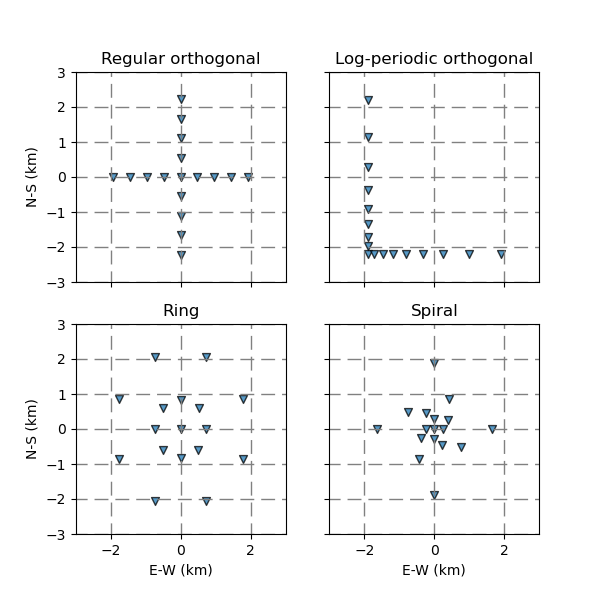

In [7]:
lon_0, lat_0 = -71.4, -30.5

plt.close('all')

geoms = {
    'Regular orthogonal': build_cross_antenna_geometry(lon_0, lat_0, 8, 8, 0.005, 0.005),
    'Log-periodic orthogonal': build_lp_ortho_antenna_geometry(lon_0, lat_0, 8, 8, 0.002, 0.002, 1.25, 1.25, recenter=True),
    'Ring': build_ring_antenna_geometry(lon_0, lat_0, 8, [0.0075, 0.02]),
    'Spiral': build_spiral_antenna_geometry(lon_0, lat_0, 4, 4, 0.0025)
}

fig, axes = plt.subplots(
    figsize=(6,6),
    nrows=2, 
    ncols=2, 
    sharex=True, 
    sharey=True
)

for label, ax in zip(geoms, axes.flatten()):
    geom = geoms[label]
    ax.scatter(
        geom['x'],
        geom['y'],
        s=32,
        marker='v',
        edgecolor='k',
        facecolor='tab:blue',
        alpha=0.75
    )
    ax.set_aspect(1)
    ax.set_title(label)
    
for ax in axes[:, 0]:
    ax.set_ylabel('N-S (km)')
for ax in axes[1]:
    ax.set_xlabel('E-W (km)')
    
for ax in axes.flatten():
    ax.grid(color='gray', ls=(2, (10, 5)), lw=1)
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)

Geometries can easily be built and saved to CSV format as below. After the array geometries have been built and saved, their responses can be analyzed in the `array_response.ipynb` notebook.

In [ ]:
geom = build_cross_antenna_geometry(lon_0, lat_0, 8, 8, 0.005, 0.005)
geom.to_csv('../data/geometry/cross_8x8_0.005x0.005.csv')

In [ ]:
geom = build_ring_antenna_geometry(lon_0, lat_0, 8, [0.0075, 0.02])
geom.to_csv('../data/geometry/ring_8x2_0.0075x0.02.csv')

In [ ]:
geom = build_spiral_antenna_geometry(lon_0, lat_0, 4, 4, 0.01)
plot_geom(geom)
geom.to_csv('../data/geometry/spiral_4x4_0.01.csv')

In [ ]:
geom = build_lp_cross_antenna_geometry(lon_0, lat_0, 8, 8, 0.002, 0.002, 1.25, 1.25)
geom.to_csv('../data/geometry/lp_cross_8x8_0.002x0.002_1.25x1.25.csv')